<a href="https://colab.research.google.com/github/juangross/cursoPDI2021/blob/main/PDI_TP7_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Desarrollar un aplicativo que implemente los conceptos de morfología en niveles de gris aquí descriptos, con un elemento estructurante 3x3. El mismo incluirá las siguientes funciones:
-Erosión (tomar el mínimo valor de luminancia de la vecindad).
-Dilatación (máximo)
-Apertura, cierre, borde morfológico
-Mediana
-Top-hat Incluir la capacidad de copiar la componente de la imagen procesada en la componente original, para poder aplicar dos o más filtrados en secuencia.


In [1]:
#@title
#importo material de trabajo
!git clone https://github.com/juangross/cursoPDI2021


Cloning into 'cursoPDI2021'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 234 (delta 74), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (234/234), 38.24 MiB | 9.77 MiB/s, done.
Resolving deltas: 100% (74/74), done.


**Bloque 2** - Definición de funciones básicas

(acumulado de los trabajos anteriores)

In [2]:
#@title

import matplotlib.pyplot as plt
import imageio as img
import numpy as np
from scipy import fftpack
import fnmatch
import os


#cargo imágenes de prueba
# Import an image from directory:
path="./cursoPDI2021/imagenes/"
ext="png"

def Mostrar(Img1,Txt1,Img2,Txt2,Img3,Txt3):
  plt.figure (dpi=200)
  ax1=plt.subplot(1,3,1)
  plt.imshow(Img1)
  plt.title(Txt1)
  #plt.setp(ax1.get_yticklabels(), fontsize=6)
  #plt.setp(ax1.get_xticklabels(), fontsize=6)
  plt.axis('off')

  ax2=plt.subplot(1,3,2, sharey=ax1)
  plt.imshow(Img2)
  plt.title(Txt2)
  #plt.setp(ax2.get_yticklabels(), visible=False)
  #plt.setp(ax2.get_xticklabels(), fontsize=6)
  plt.axis('off')

  ax3= plt.subplot(1,3,3, sharey=ax1)
  plt.imshow(Img3)
  plt.title(Txt3)
  #plt.setp(ax3.get_yticklabels(), visible=False)
  #plt.setp(ax3.get_xticklabels(), fontsize=6)
  plt.axis('off')
  plt.show()

#normalizar imagenes
#normImg: normaliza una imagen RGB
#recibe: imagen RGB
#devuelve: imagen normalizada y recortada al rango 0,1
def normImg(Img1):
  return np.clip(1/255*Img1,0,1)

#desnormalizar_RGB:
#recibe una imagen RGB como argumento, lo desnoramliza y recorta los valores al rango 0,255
#funciona con imagenes con mas de un canal
def desnormalizar_RGB (ImgRGB):
  ImgRGB=255*ImgRGB
  ImgRGB=np.rint(ImgRGB)  #redondeo a valores enteros
  ImgRGB=np.clip(ImgRGB,0,255) #recorto los valores que superen 255
  return ImgRGB


#transformo a 
def RGB_TO_YIQ(RGBImage ):
  #matriz de conversión de RGB -> YIQ
  RGB2YIQ=np.array([[0.299,0.587,0.114],
                    [0.595716,-0.274453,-0.321263],
                    [0.211456,-0.522591,0.311135]], dtype=float)

  #me baso en esta explicación del producto matricial para hacer la conversión de bases
  #https://stackoverflow.com/questions/46990838/numpy-transforming-rgb-image-to-yiq-color-space
  YIQ_image=np.zeros(RGBImage.shape, dtype=float)
  YIQ_image=np.dot(RGBImage,RGB2YIQ.T.copy())
  return YIQ_image

def YIQ_TO_RGB(YIQImage ):
  #matriz de conversión de RGB -> YIQ
  RGB2YIQ=np.array([[1,0.9663,0.6210],
                    [1,-0.2721,-0.6474],
                    [1,-0.1070,1.7046]], dtype=float)

  #me baso en esta explicación del producto matricial para hacer la conversión de bases
  #https://stackoverflow.com/questions/46990838/numpy-transforming-rgb-image-to-yiq-color-space
  RGB_image=np.zeros(YIQImage.shape, dtype=float)
  RGB_image=np.dot(YIQImage,RGB2YIQ.T.copy())
  return RGB_image

def sumaYIQ(Img1, Img2):
  input_tam=Img1.shape
  #Resultado=np.zeros(input_tam, dtype=float)
  yiq3=np.zeros(input_tam, dtype=float)

  #normalizo la imagen de entrada
  nImg1=1/255*Img1.astype('float') #la imagen queda en tipo float
  nImg2=1/255*Img2.astype('float') #la imagen queda en tipo float
  yiq1=RGB_TO_YIQ (nImg1)
  yiq2=RGB_TO_YIQ (nImg2)

  #sumo las imágenes con cada canal por separado
  #se interpolan los canales IQ mediante:
  #IC= (YA * IA + YB * IB) / (YA + YB)
  #QC= (YA * QA + YB * QB) / (YA + YB)
  #yiq3[:,:,0]=yiq1[:,:,0]/2+yiq2[:,:,0]/2 #suma el canal Y promediando
  #yiq3[:,:,1]=yiq1[:,:,1]+yiq2[:,:,1] 
  #yiq3[:,:,2]=yiq1[:,:,2]+yiq2[:,:,2] 
  
  yiq3[:,:,0]=yiq1[:,:,0]+yiq2[:,:,0] #luego hay que recortar
  yiq3[:,:,1]=(yiq1[:,:,0]*yiq1[:,:,1]+yiq2[:,:,0]* yiq2[:,:,1])/(yiq1[:,:,0]+yiq2[:,:,0])
  yiq3[:,:,2]=(yiq1[:,:,0]*yiq1[:,:,2]+yiq2[:,:,0]* yiq2[:,:,2])/(yiq1[:,:,0]+yiq2[:,:,0])
  #print (yiq3)

  #recorto los valores extremos y converito nuevamente a RGB
  yiq3[:,:,0]=np.clip(yiq3[:,:,0],0,1) #recorto los valores Y
  yiq3[:,:,1]=np.clip(yiq3[:,:,1],-.5957,.5957) #recorto los valores I
  yiq3[:,:,2]=np.clip(yiq3[:,:,2],-.5226,.5226) #recorto los valores Q
  Img3= YIQ_TO_RGB(yiq3)
  #print (yiq3)

  #desnormalizar
  Img3=255*Img3
  Img3=np.rint(Img3)  #redondeo a valores enteros
  Img3=np.clip(Img3,0,255) #recorto los valores que superen 255
  return Img3


#ContarValores(): cuenta valores contenidos en una lista basado en otra lista con las escalas (bins)
#Lista: lista que contiene los valores a calcular el histograma.
#Bins: lista con los rangos de valores a usar como rangos de cada Bin
#   Al hacer "lista < valor" se produce otra lista cuyo contenido es booleano
#   pero y cuyos valores True cumplen con la condición
#   el resultado de la línea completa es una máscara booleana donde aparecen valores True 
#   en las posiciones cuyos valores se encuentran dentro del rango establecido por los bins

def ContarValores(Lista, lista_Bins):
  size=len(lista_bins)
  cont = np.zeros(size)
  #cont = np.zeros(N_bins+1)
  for i in range (0, (size -1)):
#   print(np.count_nonzero(Lista>=Bins[i]) & (Lista<Bins[i+1]).sum())
    cont[i]=np.count_nonzero(Lista>=lista_bins[i]) & (Lista<lista_bins[i+1]).sum()
  return cont


#Funciones usadas para el ajuste del canal Y por coeficiente alfa y por función

#ClipYIQ(): toma una imagen en YIQ y aplica los coeficientes de recorte a los valores para mantenerlos en el rango YIQ 
def ClipYIQ(ImgYIQ):
  ImgYIQ[:,:,0]=np.clip(ImgYIQ[:,:,0],0,1) #recorto los valores Y
  ImgYIQ[:,:,1]=np.clip(ImgYIQ[:,:,1],-.5957,.5957) #recorto los valores I
  ImgYIQ[:,:,1]=np.clip(ImgYIQ[:,:,1],-.5226,.5226) #recorto los valores Q
  return ImgYIQ


#escalaYIQparte1(): realiza la conversión de RGB a YIQ 
def escalaYIQpartel(RGBImage):
  YIQimage=np.zeros(RGBImage.shape, dtype=float)

  #normalizo la imagen de entrada
  nRGBImage=1/255*RGBImage.astype('float') #la imagen queda en tipo float
  YIQimage=RGB_TO_YIQ (nRGBImage)
  return YIQimage
  

#escalaYIQparte2(): realiza la conversión de la imagen YIQ a RGB, y devuelve una imagen RGB desnormalizada lista para mostrar
def escalaYIQparte2 (YIQimage):
  #Img3= YIQ_TO_RGB(yiq3)
  RGBResultImage= YIQ_TO_RGB(YIQimage)

  #desnormalizar
  RGBResultImage=255*RGBResultImage
  RGBResultImage=np.rint(RGBResultImage)  #redondeo a valores enteros
  RGBResultImage=np.clip(RGBResultImage,0,255) #recorto los valores que superen 255
  return RGBResultImage


def ListarArchivos(path):
  from os import listdir
  from os.path import join, isfile
  
#  #listado de archivos a procesar
#  for file in os.listdir(path):
#    if fnmatch.fnmatch(file, '*.png'):
#      print (file.split(".")[:-1])
#  #print(file)
        
  lista = [".".join(f.split(".")[:-1])  for f in os.listdir(path) if f.endswith('.png')]
  return lista

def CreaDatos(path,archi,ext):
  #Lee imagen con el formato actual
  Img1=(img.imread(f"{path}{archi}.{ext}"))      #lee con imageio
  Img1=Img1.astype('float')/255 #normalizo
  Img1=np.clip(Img1,0.,1.)  #recorto los valores extremos al rango [0:1] 
  #print("leyendo archivo:", f"{path}{archi}.{ext}", Img1.shape)
  
  Img1_yiq=RGB_TO_YIQ(Img1)
  dimension=Img1_yiq.shape
  #print(Img1_yiq.shape)

  #FFT de la imagen original
  fimg = np.zeros(Img1_yiq[:,:,0].shape)
  fimg = np.fft.fft2(Img1_yiq[:,:,0]) #fft del canal Y de la imagen en YIQ
  #fimg = np.fft.fftshift(fimg) #ajusto al centro
  #print(fimg.shape)
  #print(fimg)

  #magnitud y fase de la imagen original
  mag = np.zeros(fimg.shape)
  mag_log = np.zeros(dimension)
  phase = np.zeros(fimg.shape)
  mag = np.abs(fimg)  

  # Coef BMP <- round( 32 * log( coef TF ) )
  mag_log[:,:,0] = np.round(np.log(mag)*32)      #ajuste propuesto por Claudio
  #los datos de magnitud quedan escalados en el rango [0:255]
  #NOTA: grabo la magnitud en el canal 0, para que grabe en el canal R de la imagen en disco

  #mag_log= mag   #bypass para pruebas
  phase = np.angle(fimg)  
  #np.angle devuelve un array en el rango [-pi : pi]
  #lo escalo y desplazo para poder meterlo en el rango [0:255]
  phase_shift = np.add(phase,3.141592653589793)
  phase_scaled= phase_shift *40           #6.28 * 40 = 250
  phase_round= np.zeros(dimension)
  phase_round[:,:,0]= np.round(phase_scaled)     #datos de fase escalados para escribir en archivo
  #NOTA: grabo la fase en el canal 0, para que grabe en el canal R de la imagen en disco

  #genero los archivos de magnitud y fase separados para usar en la síntesis cruzada
  plt.imsave(f"{path}{archi}.m", mag_log.astype('uint8'), format='bmp')
  plt.imsave(f"{path}{archi}.a", phase_round.astype('uint8'), format='bmp')

  #print("datos creados:",f"{path}{archi}.m")
  #print("datos creados:",f"{path}{archi}.a")
  
  #en un inicio probe grabar los datos de magnitud y fase directamente en un archivo de texto
  #np.savetxt(f"{path}{archi}.m", mag, fmt='%.4e')
  #np.savetxt(f"{path}{archi}.a", phase, fmt='%.4e')




**Bloque 3** - función de convolución

In [3]:
#@title



#Filtrar: aplica el kernel a la imagen, mediante una convolución
#retorna: matriz compleja representando la imagen filtrada
#observaciones: NO TRATA los bordes (por ahora)


def filtrar(fimg, kernel):
  fimg_mod=np.zeros(fimg.shape,dtype='float')

  #calculo límites del kernel
  kx=kernel.shape[0]//2  +1 #ancho del kernel /2
  ky=kernel.shape[0]//2  +1 #alto del kernel /2
  #print(kx,ky)
  #si el kernel es d e3x3, el valor origne debe ser 1,1


  for i in range(kx,fimg.shape[0]-kx,1):
      for j in range(ky, fimg.shape[1]-ky,1):
            ven=fimg[i-kx:i+kx-1,    j-ky:j+ky-1]
            fimg_mod[i,j]=np.sum(np.multiply(ven, kernel ))
            

#trabajo los bordes (en progreso, tiene errorres)
#borde superior
  for i in range(0,kx):
      for j in range(ky, fimg.shape[1]-ky,1):
            #slice desde el borde superior hasta el alto del kernel/2
            ven=fimg[i:i+kx-1,  j-ky:j+ky-1]
            #print(ven.shape)
            minikernel=kernel[kx:kernel.shape[0], :] 
            #print(minikernel.shape)
            fimg_mod[i,j]=np.sum(np.multiply(ven, minikernel))
      #print("[SUP] posicion: ",i,j," | ventana: ", ven.shape, " | kernel: ",minikernel.shape)

#borde inferior
  for i in range(fimg.shape[0]-kx,fimg.shape[0]):
      for j in range(ky, fimg.shape[1]-ky,1):
            #slice desde el borde inferior hasta el alto de la imagen
            ven=fimg[i-kx:i,  j-ky:j+ky-1]
            #print(ven.shape)
            minikernel=kernel[0:kx, 0:kernel.shape[1]] 
            #print(minikernel.shape)
            fimg_mod[i,j]=np.sum(np.multiply(ven, minikernel))
      #print("[INF] posicion: ",i,j," | ventana: ", ven.shape, " | kernel: ",minikernel.shape)

#borde izquierdo
  for i in range (kx,fimg.shape[0]-kx,1):
      for j in range(0,ky):
            #slice desde el borde inferior hasta el alto de la imagen
            ven=fimg[i-kx:i+kx-1, 0:j+ky-1]
            #print(ven.shape)
            minikernel=kernel[:, -j+ky:kernel.shape[1]] 
            #print(minikernel.shape)
            #print("ven: ",ven.shape, " - kernel: ",minikernel.shape)
            fimg_mod[i,j]=np.sum(np.multiply(ven, minikernel))
      #print("[IZQ] posicion: ",i,j," | ventana: ", ven.shape, " | kernel: ",minikernel.shape)

#borde derecho
  for i in range (kx,fimg.shape[0]-kx,1):
      for j in range(fimg.shape[1]-ky,fimg.shape[1]-ky):
            #slice desde el borde inferior hasta el alto de la imagen
            ven=fimg[i-kx:i+kx-1, j:j+ky-1]
            #print(ven.shape)
            minikernel=kernel[:, 0:ky+fimg.shape[1]-j] 
            #print(minikernel.shape)
            #print("ven: ",ven.shape, " - kernel: ",minikernel.shape)
            fimg_mod[i,j]=np.sum(np.multiply(ven, minikernel))
      #print("[DER] posicion: ",i,j," | ventana: ", ven.shape, " | kernel: ",minikernel.shape)

  return fimg_mod



  #trabajo con el canal Y de la imagen, aplico el filtro a la magnitud de la FFT
  #mag: magnitud de la FFT del canal Y de la imagen cargada en el bloque 3
  fimg_mod=np.zeros(Img1_yiq.shape,dtype=Img1.dtype)
  #print("imagen orignal: ", mag.shape)
  #print("kernel: ", kernel.shape)


dilatacion3x3=1/9* np.array([[1,1,1],
                 [1,1,1],
                 [1,1,1]])

erosion3x3=1/9* np.array([[1,1,1],
                 [1,1,1],
                 [1,1,1]])

def erosion3(fimg, kernel):
  fimg_mod=np.zeros(fimg.shape,dtype='float')

  #calculo límites del kernel
  kx=kernel.shape[0]//2  +1 #ancho del kernel /2
  ky=kernel.shape[0]//2  +1 #alto del kernel /2
  #print(kx,ky)
  #si el kernel es d e3x3, el valor origne debe ser 1,1

#      fimg_mod[:,:,0]=erosion(Img1_yiq[:,:,0], kernel)

  for i in range(kx,fimg.shape[0]-kx,1):
      for j in range(ky, fimg.shape[1]-ky,1):
            ven=fimg[i-kx:i+kx-1,    j-ky:j+ky-1]
            fimg_mod[i,j]=np.min(ven)
  return fimg_mod


def dilatacion3(fimg, kernel):
  fimg_mod=np.zeros(fimg.shape,dtype='float')

  #calculo límites del kernel
  kx=kernel.shape[0]//2  +1 #ancho del kernel /2
  ky=kernel.shape[0]//2  +1 #alto del kernel /2
  #print(kx,ky)
  #si el kernel es d e3x3, el valor origne debe ser 1,1

  for i in range(kx,fimg.shape[0]-kx,1):
      for j in range(ky, fimg.shape[1]-ky,1):
            ven=fimg[i-kx:i+kx-1,    j-ky:j+ky-1]
            fimg_mod[i,j]=np.max(ven)
  return fimg_mod



def mediana3x3(fimg):
  fimg_mod=np.zeros(fimg.shape,fimg.dtype)
  kernel=1/9* np.array([[1,1,1],
                 [1,1,1],
                 [1,1,1]])
  #calculo límites del kernel
  kx=kernel.shape[0]//2  +1 #ancho del kernel /2
  ky=kernel.shape[0]//2  +1 #alto del kernel /2
  #print(kx,ky)
  #si el kernel es de 3x3, el valor origne debe ser 1,1

  for i in range(kx,fimg.shape[0]-kx,1):
      for j in range(ky, fimg.shape[1]-ky,1):
            ven=fimg[i-kx:i+kx-1,    j-ky:j+ky-1]
            fimg_mod[i,j]=np.mean(ven)
  return fimg_mod



def apertura(fimg):
  print("fimg: ", fimg.shape)

  fimg_mod=np.zeros(fimg.shape,dtype=fimg.dtype)
  if len(fimg_mod.shape) >2:
    fimg_mod[:,:,0]= erosion3(fimg[:,:,0], erosion3x3)
    fimg_mod[:,:,0]= dilatacion3(fimg_mod[:,:,0], dilatacion3)
  else:
    fimg_mod =erosion3(fimg, erosion3x3)
    fimg_mod =dilatacion3(fimg_mod, dilatacion3x3)

  return fimg_mod

def cierre(fimg):
  fimg_mod=np.zeros(fimg.shape,dtype=fimg.dtype)
  if len(fimg_mod.shape) >2:
    fimg_mod[:,:,0]= dilatacion3(fimg[:,:,0], dilatacion3)
    fimg_mod[:,:,0]= erosion3(fimg_mod[:,:,0], erosion3x3)
    
  else:
    fimg_mod =dilatacion3(fimg, dilatacion3x3)
    fimg_mod =erosion3(fimg_mod, erosion3x3)
    

  return fimg_mod

#implemento borde exterior = dilatacion - original
def bexterior(fimg):
  fimg_mod=np.zeros(fimg.shape,dtype=fimg.dtype)
  if len(fimg_mod.shape) >2:
    fimg_mod[:,:,0]= dilatacion3(fimg[:,:,0], dilatacion3)
    fimg_mod[:,:,0]= fimg_mod[:,:,0] -fimg[:,:,0]

  else:
    fimg_mod =dilatacion3(fimg, dilatacion3x3)
    fimg_mod= fimg_mod-fimg
  return fimg_mod

#implemento borde interior = original - erosion
def binterior(fimg):
  fimg_mod=np.zeros(fimg.shape,dtype=fimg.dtype)
  if len(fimg.shape) >2:
    fimg_mod[:,:,0]= erosion3(fimg[:,:,0], erosion3x3)
    fimg_mod[:,:,0]= fimg[:,:,0] - fimg_mod[:,:,0]
  else:
    fimg_mod =erosion3(fimg, erosion3x3)
    fimg_mod= fimg -fimg_mod 
  return fimg_mod



#implemento gradiente = dilatación - erosion
def gradiente(fimg):
  fimg_mod=np.zeros(fimg.shape,dtype=fimg.dtype)
  ero=np.zeros(fimg.shape,dtype=fimg.dtype)
  if len(fimg.shape) >2:
    fimg_mod[:,:,0]= dilatacion3(fimg[:,:,0], dilatacion3)
    ero[:,:,0]= erosion3(fimg[:,:,0], erosion3x3)
    fimg_mod[:,:,0]=  fimg_mod[:,:,0] - ero[:,:,0]
  else:
    fimg_mod =dilatacion3(fimg, dilatacion3x3)
    ero =erosion3(fimg, erosion3x3)
    fimg_mod= fimg_mod  - ero
  return fimg_mod




**Bloque 4** - leer una imagen y pasarla a YIQ

NOTA: para usar el resultado de la última imagen procesada, utilizar la imagen llamada **"LAST"**



Canales:  (412, 506, 3)
valor máximo:  239
leyendo archivo: ./cursoPDI2021/imagenes/plantaciones1.png (412, 506, 3)
Canales YIQ:  (412, 506, 3)
Canales:  (412, 506, 3)
valor máximo:  0.9372549019607843


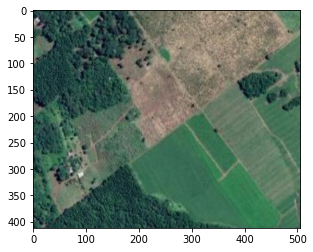

In [25]:
#cargo imágenes de prueba
# Import an image from directory:
path="./cursoPDI2021/imagenes/"
ext="png"

#Procurar buscar imágenes que tengan el mismo tamaño
archi = "plantaciones1" #@param [ 'last','cuadrado_hueco_150p', 'cuadrado_1p', 'circulo_50p', 'rombo_2', 'rectangulo_25x100p', 'cuadrado_10x10p', 'circulo_20p', 'triangulos_2', 'milo4r', 'cuadrado_5x5p','triangulo','rectangulo_100x25p','chip1r','chip2','chip3-gray', 'plantaciones1', 'mac_atrofica','mac_subatr']
#magnitud_modificada=  "1:1" #@param [ "1:1", "log Claudio"]


#Lee imagen con el formato actual
Img1=(img.imread(f"{path}{archi}.{ext}"))      #lee con imageio
print("Canales: ", Img1.shape)
print("valor máximo: ",np.max(Img1))

Img1=Img1.astype('float')/255 #normalizo
Img1=np.clip(Img1,0.,1.)  #recorto los valores extremos al rango [0:1] 
print("leyendo archivo:", f"{path}{archi}.{ext}", Img1.shape)
plt.imshow( Img1, cmap='gray')

Img1_yiq=np.zeros(Img1.shape)
print("Canales YIQ: ", Img1_yiq.shape)
if (len(Img1.shape) <=2):
  Img1_yiq=Img1
  
else:
  Img1_yiq=RGB_TO_YIQ(Img1)
  #Img1_yiq=Img1

print("Canales: ", Img1_yiq.shape)
print("valor máximo: ",np.max(Img1))



:**Bloque 5** - aplico filtro a la imagen seleccionada en bloque 


pasadas: cantidad de veces que se aplica el filtro seleccionado

NOTA: se recomienda aplicar procesamiento O filtro o detección de bordes. la lógica de apilamiento de procesos no está creada.

Img1_yiq:  (412, 506, 3)
fimg_mod:  (412, 506, 3)


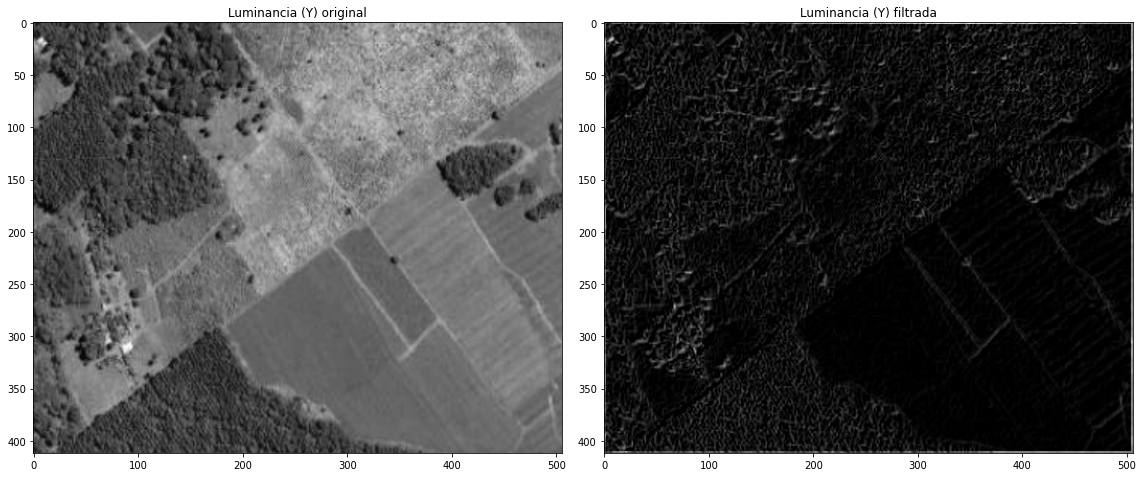

In [28]:
import numpy as np


kbartlett3=1/16* np.array([[1,2,1],
                 [2,4,2],
                 [1,2,1]])
#print("kernel: ",kernel)
kbartlett5=1/81* np.array([[1,2,3,2,1],
                 [2,4,6,4,2],
                 [3,6,9,6,3],
                 [2,4,6,4,2],
                 [1,2,3,2,1]])

kbartlett7=1/256* np.array([[1,2,3,4,3,2,1],
                     [2,4,6,8,6,4,2],
                     [3,6,9,12,9,6,3],
                     [4,8,12,16,12,8,4],
                     [3,6,9,12,9,6,3],
                     [2,4,6,8,6,4,2],
                     [1,2,3,4,3,2,1]])

gauss5=1/256* np.array([[1,4,6,4,1],
                 [4,16,24,16,4],
                 [6,24,36,24,6],
                 [4,16,24,16,4],
                 [1,4,6,4,1]])

gauss7=1/4096* np.array([[1,6,15,20,15,6,1],
                 [6,36,90,120,90,36,6],
                 [15,90,225,300,225,90,15],
                 [20,120,300,400,300,120,20],
                 [15,90,225,300,225,90,15],
                 [6,36,90,120,90,36,6],
                 [1,6,15,20,15,6,1]
                 ])


laplaciano1= np.array([ [0.0,0.0,0.0,0.0,0.0],
                        [0,-1,2,-1,0.0],
                        [0,-2,4,-2,0.0],
                        [0,-1,2,-1,0],
                        [0,0,0,0,0]] )

laplaciano2= np.array([ [1.0,-4.0,6.0,-4.0,1.0],
                        [-4,16,-24,16,-4],
                        [6,-24,36	,24,6],
                        [-4,16,-24,16,-4],
                        [1,-4,6,-4,1] ])

laplaciano3= np.array([ [1.0,4,-10,4,1],
                        [4,16,40,16,4],
                        [-10,-40,100,-40,-10],
                        [4,16,40,16,4],
                        [1,4,-10,4,1]
                       ])
laplaciano_v4= np.array([ [0,-1,0],
                        [-1,4,-1],
                        [0,-1,0]
                        ])

laplaciano_v8= np.array([ [-1,-1,-1],
                        [-1,8,-1],
                        [-1,-1,-1]
                        ])


#kernels Sobel
#referencias: https://es.wikipedia.org/wiki/Operador_Sobel
sobel_N= np.array([ [-1,-2,-1],
                    [0,0,0],
                    [1,2,1]
                    ])
sobel_NE= np.array([[0,-1,-2],
                    [1,0,-1],
                    [2,1,0]
                     ])

sobel_SE= np.array([[0,1,2],
                    [-1,0,1],
                    [-2,-1,0]
                     ])

sobel_NO= np.array([[-2,-1,0],
                    [-1,0,1],
                    [0,1,2]
                     ])

sobel_SO= np.array([[2,1,0],
                    [1,0,-1],
                    [0,-1,-2]
                     ])
sobel_E= np.array([ [1,0,-1],
                    [2,0,-2],
                    [1,0,-1]
                    ])
sobel_O= np.array([ [-1,0,1],
                    [-2,0,2],
                    [-1,0,1]
                    ])
sobel_S= np.array([ [1,2,1],
                    [0,0,0],
                    [-1,-2,-1]
                    ])

#matriz de prueba, ver planilla de cálculo
mprueba=np.array([[1,2,3,4,5,6],
     [1,2,3,4,5,6],
     [1,2,3,4,5,6],
     [1,2,3,4,5,6],
     [1,2,3,4,5,6],
     [1,2,3,4,5,6]])

#kernel=gauss5
procesamiento1 = "borde interior" #@param [ 'ninguno','dilatacion3x3','erosion3x3','apertura', 'cierre', 'borde exterior', 'borde interior', 'gradiente', 'mediana', 'top-hat']

flt = "ninguno" #@param [ 'ninguno','kbartlett3x3', 'kbartlett5x5', 'kbartlett7','gauss5x5','gauss7x7','laplaciano1','laplaciano2','laplaciano3','laplaciano_v4','laplaciano_v8']

if flt== "kbartlett3x3":  kernel=kbartlett3  
elif flt== "kbartlett5x5":  kernel=kbartlett5
elif flt== "kbartlett7x7":  kernel=kbartlett7
elif flt== "gauss5x5":  kernel=gauss5
elif flt== "gauss7x7":  kernel=gauss7
elif flt== "laplaciano1":  kernel=laplaciano1
elif flt== "laplaciano2":  kernel=laplaciano2
elif flt== "laplaciano3":  kernel=laplaciano3
elif flt== "laplaciano_v4":  kernel=laplaciano_v4
elif flt== "laplaciano_v8":  kernel=laplaciano_v8
elif flt== "dilatacion3x3":  kernel=dilatacion3
elif flt== "ninguno":    kernel=np.array(np.ones([3,3]))
pasadas = "1" #@param [ '1', '2', '3','4','5']


deteccion_bordes = "ninguno" #@param [ 'ninguno','sobel_N','sobel_NE', 'sobel_E','sobel_SE', 'sobel_S', 'sobel_SO','sobel_O','sobel_NO']
if deteccion_bordes== "ninguno":    kernel2=np.array(np.ones([3,3]))
elif deteccion_bordes== "sobel_N":  kernel2=sobel_N
elif deteccion_bordes== "sobel_NE": kernel2=sobel_NE
elif deteccion_bordes== "sobel_E":  kernel2=sobel_E
elif deteccion_bordes== "sobel_SE": kernel2=sobel_SE
elif deteccion_bordes== "sobel_S":  kernel2=sobel_S
elif deteccion_bordes== "sobel_SO":  kernel2=sobel_SO
elif deteccion_bordes== "sobel_O":  kernel2=sobel_O
elif deteccion_bordes== "sobel_NO":  kernel2=sobel_NO

#trabajo con el canal Y de la imagen, aplico el filtro a la magnitud de la FFT
#mag: magnitud de la FFT del canal Y de la imagen cargada en el bloque 3
fimg_mod=np.zeros(Img1_yiq.shape,dtype=Img1.dtype)
#print("imagen orignal: ", mag.shape)
print("Img1_yiq: ", Img1_yiq.shape)
print("fimg_mod: ", fimg_mod.shape)

if procesamiento1 == "dilatacion3x3":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0]= dilatacion3(Img1_yiq[:,:,0], erosion3x3)
    else:
      fimg_mod =dilatacion3(Img1_yiq, erosion3x3)
elif procesamiento1 == "erosion3x3":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0]= erosion3(Img1_yiq[:,:,0], erosion3x3)
    else:
      fimg_mod= erosion3(Img1_yiq, erosion3x3)
elif procesamiento1 == "apertura":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0] = apertura(Img1_yiq[:,:,0])
    else:
      fimg_mod = apertura(Img1_yiq)

elif procesamiento1 == "cierre":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0]= cierre(Img1_yiq[:,:,0])
    else:
      fimg_mod= cierre(Img1_yiq)

elif procesamiento1 == "borde exterior":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0]= bexterior(Img1_yiq[:,:,0])
    else:
      fimg_mod= bexterior(Img1_yiq)


elif procesamiento1 == "borde interior":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0]= binterior(Img1_yiq[:,:,0])
    else:
      fimg_mod= binterior(Img1_yiq)

elif procesamiento1 == "gradiente":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0]= gradiente(Img1_yiq[:,:,0])
    else:
      fimg_mod= gradiente(Img1_yiq)

elif procesamiento1 == "mediana":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0]= mediana3x3(Img1_yiq[:,:,0])
    else:
      fimg_mod= mediana3x3(Img1_yiq)


elif procesamiento1 == "top-hat":
  for i in range (0, int(pasadas)):
    if len(fimg_mod.shape) >2:
      fimg_mod[:,:,0] = Img1_yiq[:,:,0] - apertura(Img1_yiq[:,:,0])
    else:
      fimg_mod = Img1_yiq - apertura(Img1_yiq)



#  #trabajo con el canal Y de la imagen, aplico el filtro a la magnitud de la FFT
#  #mag: magnitud de la FFT del canal Y de la imagen cargada en el bloque 3
#  fimg_mod=np.zeros(Img1_yiq.shape,dtype=Img1.dtype)
#  #print("imagen orignal: ", mag.shape)
#  #print("kernel: ", kernel.shape)
#
#  for i in range (0, int(pasadas)):
#    fimg_mod[:,:,0]=erosion(Img1_yiq[:,:,0], kernel)
#    print ("Pasada: ", i+1)

if deteccion_bordes !="ninguno":
  if len(Img1_yiq.shape)>2:
    fimg_mod[:,:,0]=filtrar(Img1_yiq[:,:,0], kernel2)
  else:
    fimg_mod=filtrar(Img1_yiq, kernel2)


elif flt!="ninguno":

#  #trabajo con el canal Y de la imagen, aplico el filtro a la magnitud de la FFT
#  #mag: magnitud de la FFT del canal Y de la imagen cargada en el bloque 3
#  fimg_mod=np.zeros(Img1_yiq.shape,dtype=Img1.dtype)
#  #print("imagen orignal: ", mag.shape)
#  #print("kernel: ", kernel.shape)

  for i in range (0, int(pasadas)):
    if len(Img1_yiq.shape)>2:
      fimg_mod[:,:,0]=filtrar(Img1_yiq[:,:,0], kernel)
    else:
      fimg_mod=filtrar(Img1_yiq, kernel)
    print ("Pasada: ", i+1)

  if deteccion_bordes !="ninguno":
    if len(Img1_yiq.shape)>2:
      fimg_mod[:,:,0]=filtrar(fimg_mod[:,:,0], kernel2)
    else:
      fimg_mod=filtrar(fimg_mod, kernel2)


#print("imagen orignal: ", mag)
#print("imagen filtrada: ", fimg_mod)



#inicializo el array que contiene la imagen reconstruida 
#y le precargo los canales YQ de la imagen original
#imagen reconstruida YIQ = imagen orginal con canal Y alterado, IQ originales
Img1_yiq_mod=np.zeros(Img1_yiq.shape, Img1_yiq.dtype)

if len(Img1_yiq.shape)>2:
  Img1_yiq_mod[:,:,0]=fimg_mod[:,:,0]
  #Img1_yiq_mod[:,:,1]=Img1_yiq[:,:,1]     #copio canal I original
  #Img1_yiq_mod[:,:,2]=Img1_yiq[:,:,2]     #copio canal Q original
else:
  Img1_yiq_mod=fimg_mod
#Hago clip sólo del canal Y
Img1_yiq_mod=np.clip(Img1_yiq_mod,0,1) #recorto los valores Y
#Img1_yiq_mod=ClipYIQ(Img1_yiq_mod)          #recorto la imagen YIQ al rango válido

#Img1_mod= YIQ_TO_RGB(Img1_yiq_mod)          #convierte espacio YIQ a RGB
#Img1_mod=255*Img1_mod                       #desnormalizo la imagen
#Img1_mod=np.rint(Img1_mod)                  #redondeo a valores enteros
#Img1_mod=np.clip(Img1_mod,0,255)            #recorto los valores que superen 255
#print(Img1_mod)

#figura base
fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(16, 16))


#Luminancia original
#desnormalizar
if len(Img1_yiq.shape)>2:
  Img1_rgb= desnormalizar_RGB(Img1_yiq[:,:,0])
else:
  Img1_rgb= desnormalizar_RGB(Img1_yiq)
#Img1_rgb=255*Img1_yiq[:,:,0]
#Img1_rgb=np.rint(Img1_rgb)  #redondeo a valores enteros
#Img1_rgb=np.clip(Img1_rgb,0,255) #recorto los valores que superen 255

axs[0].imshow(Img1_rgb.astype('uint8'),cmap= 'gray')
axs[0].set_title("Luminancia (Y) original")

#magnitud del espectro centrado
#axs[1].imshow(np.abs(fimg).astype('uint8'),cmap= 'gray')
#axs[1].set_title("Espectro Magnitud canal Y original")

#axs[2].imshow(np.abs((fimg_mod)).astype('uint8'),cmap= 'gray')
#axs[2].imshow(np.clip(np.abs((fimg_mod)),0,255).astype('uint8'),cmap= 'gray')
#axs[2].set_title("Espectro Magnitud canal Y FILTRADA")

#axs[3].imshow(phase.astype('uint8'),cmap= 'gray')
#axs[3].set_title("Fase original")


Img1_yiq_mod=Img1_yiq_mod*255
if len(Img1_yiq.shape)>2:
  axs[1].imshow( Img1_yiq_mod[:,:,0].astype('uint8'),cmap='gray')
  axs[1].set_title("Luminancia (Y) filtrada")
  plt.show()

  #genero archivo para poder reutilizarlo luego
  archi='last'
  img.imwrite(f"{path}{archi}.{ext}",Img1_yiq_mod[:,:,0].astype('uint8'), format="PNG-PIL")

else:
  axs[1].imshow( Img1_yiq_mod.astype('uint8'),cmap='gray')
  axs[1].set_title("Luminancia (Y) filtrada")
  plt.show()
  #genero archivo para poder reutilizarlo luego
  archi='last'
  img.imwrite(f"{path}{archi}.{ext}",Img1_yiq_mod.astype('uint8'), format="PNG-PIL")




